In [1]:
from fastai.vision.all import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import timm

In [2]:
import torch

# Check if GPU is available and being used
if torch.cuda.is_available():
    print('Using GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else: 
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Ti


# Project understanding

**The problem:** Identify the presence of metastases from digital histopathology images.

# Data visualization

(96, 96)


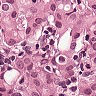

In [22]:
train_path = '../data/raw/train/'
files = get_image_files(train_path)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(96)

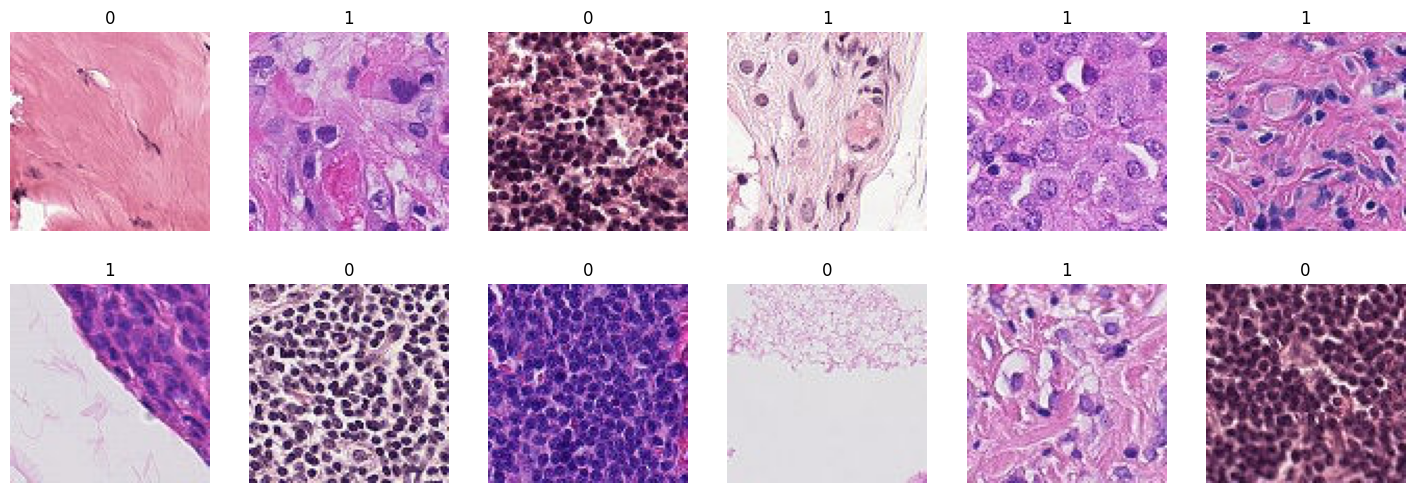

In [37]:
dls.valid.show_batch(max_n=12, nrows=2)

In [23]:
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=0) # multiprocessing isn't available... 
pd.Series(sizes).value_counts()

(96, 96)    220025
Name: count, dtype: int64

There are 220 025 images. All images are the same size (96px x 96px).

Number of images with tumor tissue: 89117
Number of images without tumor tissue: 130908


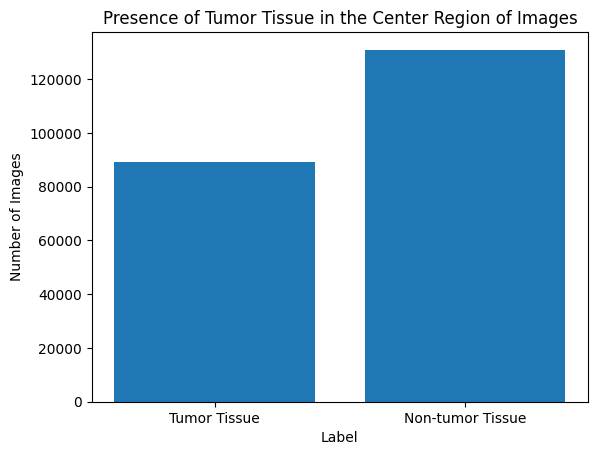

In [31]:
import matplotlib.pyplot as plt

# Images with tumor tissue
num_tumor = train_df['label'].sum()

# Images without tumor tissue
num_non_tumor = len(train_df) - num_tumor

# Bar chart
labels = ['Tumor Tissue', 'Non-tumor Tissue']
values = [num_tumor, num_non_tumor]
fig, ax = plt.subplots()
ax.bar(labels, values)

# Labels
ax.set_xlabel('Label')
ax.set_ylabel('Number of Images')
ax.set_title('Presence of Tumor Tissue in the Center Region of Images')

# Print out the number of images with and without tumor tissue
print('Number of images with tumor tissue:', num_tumor)
print('Number of images without tumor tissue:', num_non_tumor)

# Show graph
plt.show()

There are 89 117 images with tumor tissue and 130 908 images without tumor tissue. 

# Pre-processing

Loading the training labels file and setting train path:

In [3]:
train_path = '../data/raw/train/'
train_df = pd.read_csv('../data/raw/train_labels.csv')

Creating a ImageDataLoader:

In [4]:
dls = ImageDataLoaders.from_df(
    train_df, 
    path=train_path,
    suff='.tif',
    shuffle=True
    )

# Model selection

Create a learner:

In [8]:
learn = vision_learner(dls, 'resnet26d', metrics=accuracy, pretrained=True)

# Model training

Using lr_find() to find the optimal learning rate:

SuggestedLRs(valley=0.0002754228771664202)

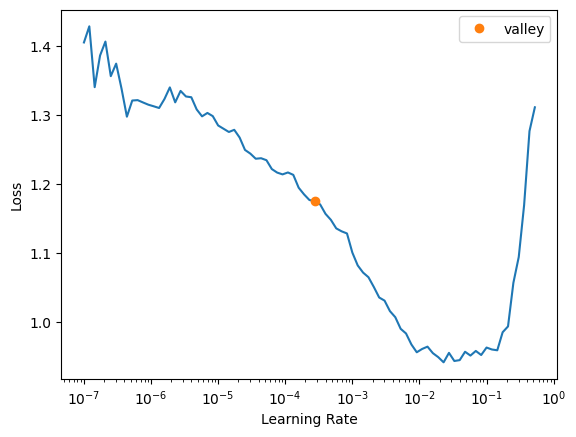

In [9]:
learn.lr_find()

The `lr_find()` function suggests a learning rate of 0.002. Since `lr_find()` is typically cautious with its recommendataions, I will be using a bit higher learning rate of 0.01.

Training the model:

In [10]:
learn.fine_tune(epochs=5, base_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.259101,0.215740,0.916191,04:34


epoch,train_loss,valid_loss,accuracy,time
0,0.163822,0.138820,0.948892,05:05
1,0.114592,0.104410,0.965436,05:04
2,0.060323,0.091886,0.970776,05:04
3,0.026981,0.118932,0.972549,05:04
4,0.006267,0.140148,0.973321,05:04


In [14]:
# Save the trained model
learn.export('model.pkl')